# Hyperparameters

In [1]:
IS_TRAINING_MODE = True

# training data paramters
TRAINING_PERCENT_PARAMETER = 0.15 #if IS_TRAINING_MODE else 0.015
DATA_PATH = './data'

# Development Parameters
DEBUG_PARAMETER = False
PARAM_FINAL_IMAGES = False
PARAM_GENERATE_CONFIDENCE_MATRIX = True

# Hyper parameters - these are from the last 15% run
sfs_features_to_select = 3

# Best Params for All Hyperparameters
logistic_regression__C = 1.0
logistic_regression__class_weight = 'balanced'
logistic_regression__fit_intercept = True
logistic_regression__penalty = 'l1'
logistic_regression__solver = 'liblinear'
kneighbors__algorithm = 'auto'
kneighbors__n_neighbors = 10
kneighbors__weights = None
decision_tree__criterion = 'entropy'
decision_tree__max_depth = 6
decision_tree__max_features = None
random_forest__max_features = 8
random_forest__n_estimators = 3
gradient_boost__n_estimators = 42
extremegradientboost__learning_rate = 1
extremegradientboost__max_depth = 1
extremegradientboost__n_estimators = 18
logistic_regression__features = ['rb_count', 'on_schedule', 'form_EMPTY', 'form_SHOTGUN', 'form_SINGLEBACK', ]
kneighbors__features = ['extra_ol', 'form_EMPTY', 'form_SHOTGUN', ]
decision_tree__features = ['rb_count', 'form_SHOTGUN', 'form_SINGLEBACK', 'form_VICTORY', ]
support_vector__features = ['rb_count', 'on_schedule', 'form_SHOTGUN', 'form_SINGLEBACK', 'form_VICTORY', ]
extremegradientboost__features = ['rb_count', 'form_EMPTY', 'form_SHOTGUN', 'form_SINGLEBACK', ]

# Initializing Data

## Preparing Data

### Includes

In [ ]:
import pandas as pd
import numpy as np
import math

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
from sklearn.utils import shuffle

from sklearn import tree

import pandas as pd
import numpy as np
import seaborn as sns
import time
from matplotlib import pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score , confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder

# HalvingGridSearchCV is experimental and the API might change without any deprecation cycle
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.metrics import auc as skl_auc
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import plotly.express as px

import xgboost as xgb
from xgboost import XGBClassifier

## here we're suppressing warnings
import warnings
warnings.filterwarnings('ignore')

### Load the Data

In [3]:
plays_path = f'{DATA_PATH}/plays.csv'
plays = pd.read_csv(plays_path)

In [4]:
games_path = f'{DATA_PATH}/games.csv'
games = pd.read_csv(games_path)

plays = plays.merge(games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']], left_on='gameId', right_on='gameId')

## Readying the dataset

In [5]:
def get_position_features(s: pd.Series) -> pd.Series:
    """determine wr, te, rb based on alignment; WRxTE
    """
    wr_count = te_count = rb_count = 0
    extra_ol = s.offenseFormation == "JUMBO"
    if not isinstance(s.receiverAlignment, float):
        alignment = s.receiverAlignment.split('x')
        if len(alignment):
            wr_count = int(alignment[0])
            te_count = int(alignment[1])
            rb_count = 5 - wr_count - te_count
            if extra_ol and rb_count > 1:
                rb_count -= 1 

    return pd.Series([wr_count, te_count, rb_count, extra_ol], ['wr_count', 'te_count', 'rb_count', 'extra_ol'])
def get_time_features(s: pd.Series) -> pd.Series:
    """determine total time remaining, is overtime, or within two mins
    """ 
    two_min_1st_half = 32 * 60
    two_min_2st_half = 2 * 60
    two_min_overtime = 68 * 60
    
    quarter = int(s.quarter)
    secs_remaining = math.nan
    is_inside_two_mins = is_overtime = False
    quarter_clock = s.gameClock.split(':')
    if len(quarter_clock) == 2:
        secs_in_quarter = int(quarter_clock[0]) * 60 + int(quarter_clock[1])
        if quarter <= 4:
            secs_remaining = (4 - quarter) * 15 * 60 + secs_in_quarter
        else:
            secs_remaining = secs_in_quarter
            is_overtime = True
        is_inside_two_mins = secs_in_quarter <= 120 and (quarter == 2 or quarter >= 4)

    return pd.Series([secs_remaining, is_inside_two_mins, is_overtime], ['secs_remaining', 'is_inside_two_mins', 'is_overtime'])

# v1 result - just sneak, kneel, spikie, pass, or run
plays['play_result'] = plays.apply(lambda p: 
                                   'run' if p.qbSneak == True else 
                                   'run' if p.qbKneel == True else 
                                   'pass' if p.qbSpike == True else 
                                   'pass' if p.isDropback == True else 
                                   'run', axis = 1)

# offenseFormation is NaN for qb kneels or spikes
plays['offense_formation'] = plays.apply(lambda p: 
                                   'VICTORY' if p.qbKneel == True else
                                   'MUDDLE' if p.qbSpike == True else
                                   p.offenseFormation, axis = 1)

# offense is considered on schedule if they gain at least 50% on first down, 70% on second down, or 100% on 3rd/4th. 
# this means on schedule is 1st (yards <= 10), 2nd (yards <= 5), 3rd (yards <= 3), 4th (yards <= 1)
plays['on_schedule'] = plays.apply(lambda p: 
                                   p.yardsToGo <= 10 if p.down == 1 else
                                   p.yardsToGo <= 5  if p.down == 2 else
                                   p.yardsToGo <= 3  if p.down == 3 else
                                   p.yardsToGo <= 1  if p.down == 4 else
                                   False, axis = 1)
# anything two yards or less is considered short yardage
plays['and_short'] = plays.apply(lambda p: p.yardsToGo <= 2, axis = 1)


# get score and win probability
plays['score_offset'] = plays.apply(lambda p: 
                                    p.preSnapHomeScore - p.preSnapVisitorScore if p.possessionTeam == p.homeTeamAbbr else
                                    p.preSnapVisitorScore - p.preSnapHomeScore, axis = 1)
plays['win_probability'] = plays.apply(lambda p: 
                                       p.preSnapHomeTeamWinProbability if p.possessionTeam == p.homeTeamAbbr else
                                       p.preSnapVisitorTeamWinProbability, axis = 1)

# get position counts (TE, WR, etc)
tmp = plays.apply(get_position_features, axis=1)
plays['wr_count'] = tmp['wr_count']
plays['te_count'] = tmp['te_count']
plays['rb_count'] = tmp['rb_count']
plays['extra_ol'] = tmp['extra_ol']

tmp = plays.apply(get_time_features, axis=1)
plays['secs_remaining'] = tmp['secs_remaining']
plays['is_inside_two_mins'] = tmp['is_inside_two_mins']
plays['is_overtime'] = tmp['is_overtime']

plays['off_yards_to_goal'] = plays.apply(lambda p: 100 - int(p.yardlineNumber) if p.yardlineSide == p.possessionTeam else int(p.yardlineNumber), axis = 1)
df = plays

## Prepare the training set

In [6]:
# add in dummies - doing this manually because it's simpler overall than doing column transformer
formation_dummies = pd.get_dummies(df.offense_formation, prefix='form')
df = pd.concat([df, formation_dummies], axis=1)
quarter_dummies = pd.get_dummies(df.quarter, prefix='quarter')
df = pd.concat([df, quarter_dummies], axis=1)
down_dummies = pd.get_dummies(df.down, prefix='down')
df = pd.concat([df, down_dummies], axis=1)
teams_dummies = pd.get_dummies(df.possessionTeam, prefix='team') 
df = pd.concat([df, teams_dummies], axis=1)

TARGET_FEATURE = 'play_result'
TRAINING_FEATURES = ['yardsToGo',                                                               # down and distance
                     'secs_remaining', 'is_inside_two_mins',                                    # game time
                     'wr_count', 'te_count', 'rb_count', 'extra_ol',                            # formations
                     'on_schedule', 'and_short',                                                # situational
                     'score_offset', 'win_probability',                                         # score and win probability
                     TARGET_FEATURE]

# add dummy features - using all for training
for c in formation_dummies.columns:
    TRAINING_FEATURES.append(c)
for c in quarter_dummies.columns:
    TRAINING_FEATURES.append(c)
for c in down_dummies.columns:
    TRAINING_FEATURES.append(c)
for c in teams_dummies.columns:
    TRAINING_FEATURES.append(c)

In [7]:
tmp = df[TRAINING_FEATURES]
X_train, X_test, y_train, y_test = train_test_split(tmp.drop(TARGET_FEATURE, axis = 1), 
                                                    tmp[TARGET_FEATURE],
                                                    train_size=TRAINING_PERCENT_PARAMETER,
                                                    random_state=27,
                                                    stratify = df[TARGET_FEATURE],
                                                    shuffle=True)
if DEBUG_PARAMETER:
    print(f"The training set has {len(y_train)} rows")
    print(f"The test set has {len(y_test)} rows")
    print(f"The target feature is {TARGET_FEATURE} and the {len(X_train.columns)} training columns are {[x for x in X_train.columns]}")

## Automation Layer

In [8]:
def create_roc_curve(model, X_test, y_test):
    """ Create ROC curve for model
    """
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc_value = skl_auc(fpr, tpr)

    disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
    disp2.plot()

all_best_params = {}
def print_best_params(name, best_params):
    """ Displays best hyperparameters in a format that can be copy/pasted into Hyperparameters section
    """
    if IS_TRAINING_MODE:
        return
    print(f"======== Best Params for {name} ========")
    for key in best_params:
        value = best_params[key]
        if not isinstance(value, str):
            print(f"{key} = {value}")
        else:
            print(f"{key} = '{value}'")

def append_best_params(name, best_params):
    """ Add best params for model
    """
    all_best_params.update(best_params)
    print_best_params(name, best_params)

all_runs = []
best_run = None
class ModelTrainer:
    """Automates model training, capturing output, and generating basic charts
    """
    def __init__(self, model_name, actual_model, prefix, generate_charts=True, selected_features=None, use_label_encoder=False):
        self.start_time = time.time()
        self.model_name = model_name
        self.model = actual_model
        self.prefix = prefix
        self.generate_charts = False #generate_charts
        self.training_features = None
        self.train_time = None
        self.train_accuracy = None
        self.test_accuracy = None
        self.features = selected_features if selected_features is not None else [x for x in TRAINING_FEATURES if x != TARGET_FEATURE]
        self.use_label_encoder = use_label_encoder
        
    def elapsed(self):
        elapsed_time = time.time() - self.start_time
        return f"{elapsed_time:.2f} secs"
    
    def model_predict(self, X, is_continuous):
        prediction = self.model.predict(X)
        if is_continuous:
            prediction = (prediction >= 0.5).astype(int)
        return prediction
    
    def chart_roc_and_confusion(self, is_continuous):
        fig, ax = plt.subplots(1, 2)
        if PARAM_FINAL_IMAGES:
            fig.set_size_inches(20, 12)
        else:
            fig.set_size_inches(15, 5)

        preds = self.model_predict(X_test[self.features], is_continuous)

        # need label encoder for XGB
        y_train_local = y_train
        y_test_local = y_test
        if self.use_label_encoder:
            y_train_local = LabelEncoder().fit_transform(y_train)
            y_test_local = LabelEncoder().fit_transform(y_test)

        # Confusion Matrix
        if PARAM_GENERATE_CONFIDENCE_MATRIX:
            conf_matrix = confusion_matrix(y_test_local, preds)
            disp1 = ConfusionMatrixDisplay(conf_matrix, display_labels=['run', 'pass' ])
            # plt.title("Confusion Matrix")
            disp1.plot(ax=ax[0])
            # print(f"Precision: {precision_score(y_test_local, preds, labels=['run', 'pass' ], pos_label='run'):.4f}")
            # print(f"Recall: {recall_score(y_test_local, preds, labels=['run', 'pass' ], pos_label='run'):.4f}")            

        # ROC Curve
        y_score = None
        if not is_continuous:
            y_score = self.model.predict_proba(X_test[self.features])[:, 1]
        else:
            y_score = self.model.predict(X_test[self.features])
        fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label='run') # 
        roc_auc_value = skl_auc(fpr, tpr)

        disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
        disp2.plot(ax=ax[1])
    
    def run(self, is_continuous=False):
        """Run model training and gather results for future comparison
        """
        features = self.features
        global best_run
        if not IS_TRAINING_MODE:
            print("Not training models - IS_TRAINING_MODE=False")
            return
        training_features = 0 if self.model_name == "Dummy" else len(TRAINING_FEATURES) - 1

        # need label encoder for XGB
        y_train_local = y_train
        y_test_local = y_test
        if self.use_label_encoder:
            y_train_local = LabelEncoder().fit_transform(y_train)
            y_test_local = LabelEncoder().fit_transform(y_test)

        model = self.model
        model.fit(X_train[features], y_train_local)
        predictions = model.predict(X_test[features])
        if self.use_label_encoder:
            predictions = ['run' if x == 1 else 'pass' for x in predictions]
        train_accuracy = accuracy_score(model.predict(X_train[features]), y_train_local)
        test_accuracy = accuracy_score(predictions, y_test_local) 
        self.training_features = training_features
        self.train_time = self.elapsed()
        self.train_accuracy = train_accuracy
        self.test_accuracy = test_accuracy
        if self.prefix is not None:
            X_test[f'{self.prefix}_pred'] = predictions
        all_runs.append(self)
        if best_run is None or self.test_accuracy > best_run.test_accuracy:
            best_run = self

        if PARAM_GENERATE_CONFIDENCE_MATRIX:
            self.chart_roc_and_confusion(False)

def optimize_model_params(pipeline, parameters_to_try, use_label_encoder=False):
    """Find the best parameters for this model
    """
    if IS_TRAINING_MODE:
        print("Not optimizing hyper parameters - IS_TRAINING_MODE=True")
        return
    
    # need label encoder for XGB
    y_train_local = y_train
    if use_label_encoder:
        y_train_local = LabelEncoder().fit_transform(y_train)

    model_finder = GridSearchCV(estimator = pipeline, 
                                param_grid = parameters_to_try, 
                                scoring = "accuracy",
                                n_jobs=-1,      # parallelization
                                cv = 5)
    model_finder.fit(X_train, y_train_local)
    append_best_params("LogisticRegression", model_finder.best_params_)

def show_run_output():
    """Print out model runs in markdown table
    """
    if not IS_TRAINING_MODE:
        return
    print(f"*Best Run is {best_run.test_accuracy:4f} from {best_run.model_name}*\n")
    print("| Model | Features | Train Time | Train Accuracy | Test Accuracy |")
    print("| ----- | -------- | ---------- | -------------  | -----------   |")
    for r in all_runs:
        print(f"| {r.model_name} | {r.training_features} | {r.train_time} | {r.train_accuracy:.4f} | {r.test_accuracy:.4f} |")

all_best_features = []
def find_best_features(sq_model, prefix, max_features=10, use_label_encoder=False):
    """Find the best features, will quit when local min hit
    """
    if IS_TRAINING_MODE:
        print("Not optimizing hyper parameters - IS_TRAINING_MODE=True")
        return
    best_accuracy = 0.0
    best_features = []
    
    # need label encoder for XGB
    y_train_local = y_train
    y_test_local = y_test
    if use_label_encoder:
        y_train_local = LabelEncoder().fit_transform(y_train)
        y_test_local = LabelEncoder().fit_transform(y_test)    

    last_test_accuracy = ""
    for num_features in range(1, max_features + 1):
        start = time.time()
        selector = SequentialFeatureSelector(estimator=sq_model, n_features_to_select=num_features, n_jobs=-1)
        pipeline = Pipeline([
            # ('scaler', StandardScaler()),
            ('sequential', selector)
        ])
        X_sfs = pipeline.fit_transform(X_train, y_train_local)

        best_columns = selector.get_feature_names_out()

        sq_model.fit(X_train[best_columns], y_train_local)
        # train_accuracy = accuracy_score(sq_model.predict(X_train[best_columns]), y_train)
        test_accuracy = accuracy_score(sq_model.predict(X_test[best_columns]), y_test_local)
        if last_test_accuracy == f"{test_accuracy:4f}":
            print("Test accuracy has flattened out - stopping search")
            break
        last_test_accuracy = f"{test_accuracy:4f}"

        elapsed_time = time.time() - start
        print(f"Best Training Accuracy for {num_features}: {test_accuracy:4f} in {elapsed_time:.4f} secs, features: {selector.get_feature_names_out()}")

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_features = selector.get_feature_names_out()
    print(f"\nOverall Best: {best_accuracy:4f} features: {best_features}")
    output = f"{prefix}__features = ["
    for feature in best_features:
        output += f"'{feature}', "
    output += "]"
    all_best_features.append(output)
    return best_features

def print_best_features():
    """Displays best features in a format that can be copy/pasted into Hyperparameters section
    """
    for best_feature in all_best_features:
        print(best_feature)


## EDA

### Expectation: Teams pass substantially more in the last two minutes of each half

In [9]:
df['pass_percent'] = df.apply(lambda p: 1 if p.play_result == "pass" else 0, axis = 1)
df['mins_in_half'] = df.apply(lambda p: 30 - math.ceil(p.secs_remaining / 60), axis = 1)

pass_by_min = df.loc[(df.quarter < 3), ['mins_in_half', 'pass_percent'] ].groupby(['mins_in_half']).mean('pass_percent').reset_index()

px.scatter(pass_by_min, x='mins_in_half', y='pass_percent', trendline='ols', title='Percentage of Passing Plays by Time Remaining in First Half')

In [10]:
df['mins_in_half'] = df.apply(lambda p: 60 - math.ceil(p.secs_remaining / 60), axis = 1)

pass_by_min = df.loc[(df.quarter == 3) | (df.quarter == 4), ['mins_in_half', 'pass_percent'] ].groupby(['mins_in_half']).mean('pass_percent').reset_index()

px.scatter(pass_by_min, x='mins_in_half', y='pass_percent', trendline='ols', title='Percentage of Passing Plays by Time Remaining in Second Half')

### Expectation: Teams pass more based on how much they are winning or losing

In [11]:
score_and_result = df.loc[df.quarter_1 == True, ['quarter', 'score_offset', 'pass_percent'] ].groupby(['quarter', 'score_offset']).mean('pass_percent').reset_index()
score_and_result

px.scatter(score_and_result, x='score_offset', y='pass_percent', trendline='ols', title='Odds of pass versus the score in the First Quarter')

In [12]:
df['pass_percent'] = df.apply(lambda p: 1 if p.play_result == "pass" else 0, axis = 1)
score_and_result = df.loc[df.quarter_2 == True, ['quarter', 'score_offset', 'pass_percent'] ].groupby(['quarter', 'score_offset']).mean('pass_percent').reset_index()
score_and_result

px.scatter(score_and_result, x='score_offset', y='pass_percent', trendline='ols', title='Odds of pass versus the score in the Second Quarter')

In [13]:
score_and_result = df.loc[df.quarter_3 == True, ['quarter', 'score_offset', 'pass_percent'] ].groupby(['quarter', 'score_offset']).mean('pass_percent').reset_index()
score_and_result

px.scatter(score_and_result, x='score_offset', y='pass_percent', trendline='ols', title='Odds of pass versus the score in the Third Quarter')

In [14]:
score_and_result = df.loc[df.quarter_4 == True, ['quarter', 'score_offset', 'pass_percent'] ].groupby(['quarter', 'score_offset']).mean('pass_percent').reset_index()
score_and_result

px.scatter(score_and_result, x='score_offset', y='pass_percent', trendline='ols', title='Odds of pass versus the score in the Fourth Quarter')

# Determine Hyperparameters

### Logistic Regression

In [15]:
pipeline = Pipeline([
    ('logistic_regression', LogisticRegression(max_iter=10000))
])
parameters_to_try = {
    'logistic_regression__fit_intercept': [True, False],
    'logistic_regression__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'logistic_regression__C': [1.0, 100.0, 10000.0],
    'logistic_regression__class_weight': [None, 'balanced'],
    'logistic_regression__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
}

optimize_model_params(pipeline, parameters_to_try)

Not optimizing hyper parameters - IS_TRAINING_MODE=True


In [16]:
model = LogisticRegression(fit_intercept = logistic_regression__fit_intercept,
                           penalty = logistic_regression__penalty,
                           C = logistic_regression__C,
                           class_weight = logistic_regression__class_weight,
                           solver = logistic_regression__solver)
features = find_best_features(model, "logistic_regression")

Not optimizing hyper parameters - IS_TRAINING_MODE=True


### K-Nearest Neighbors

In [17]:
pipeline = Pipeline([
    ('kneighbors', KNeighborsClassifier())
])
parameters_to_try = {
    'kneighbors__n_neighbors': np.array(range(1, 20)),
    'kneighbors__weights': [None, 'uniform', 'distance'],
    'kneighbors__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    # 'kneighbors__leaf_sizeint': ['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights']
}

optimize_model_params(pipeline, parameters_to_try)

Not optimizing hyper parameters - IS_TRAINING_MODE=True


In [18]:
model = KNeighborsClassifier(algorithm = kneighbors__algorithm,
                             n_neighbors = kneighbors__n_neighbors,
                             weights = kneighbors__weights)
features = find_best_features(model, "kneighbors")

Not optimizing hyper parameters - IS_TRAINING_MODE=True


### Decision Tree

In [19]:
pipeline = Pipeline([
    ('decision_tree', DecisionTreeClassifier(criterion='entropy'))
])
parameters_to_try = {
    'decision_tree__criterion': ['gini', 'entropy', 'log_loss'],
    'decision_tree__max_depth': np.array(range(1, 20)),
    'decision_tree__max_features': [None, 'sqrt', 'log2'],
}

optimize_model_params(pipeline, parameters_to_try)

Not optimizing hyper parameters - IS_TRAINING_MODE=True


In [20]:
model = DecisionTreeClassifier(criterion=decision_tree__criterion, 
                                    max_depth=decision_tree__max_depth, 
                                    max_features=decision_tree__max_features)
features = find_best_features(model, "decision_tree")

Not optimizing hyper parameters - IS_TRAINING_MODE=True


### Support Vector Machines

In [21]:
# pipeline = Pipeline([
#     ('support_vector', SVC(probability=False))        # avoid applying expensive Platt's calibration internally
# ])
# parameters_to_try = {
#     'support_vector__C': [0.1, 10, 1000], 
# 	'support_vector__gamma': [0.1, 10, 100], # 1, 0.1, 0.01, 0.001, 0.0001
# 	'support_vector__kernel': ['poly']
# }

# optimize_model_params(pipeline, parameters_to_try)

In [22]:
model = SVC()
features = find_best_features(model, "support_vector")

# Overall Best: 0.742667 features: ['rb_count' 'on_schedule' 'form_SHOTGUN' 'form_SINGLEBACK' 'form_VICTORY']

Not optimizing hyper parameters - IS_TRAINING_MODE=True


### Random Forest

In [23]:
pipeline = Pipeline([
    ('random_forest', RandomForestClassifier(n_estimators=5, max_features=10, oob_score=True))
])
parameters_to_try = {
    'random_forest__n_estimators': np.array(range(1, 5)),
    'random_forest__max_features': np.array(range(1, 10)),
}

optimize_model_params(pipeline, parameters_to_try)

Not optimizing hyper parameters - IS_TRAINING_MODE=True


In [24]:
if not IS_TRAINING_MODE:
    n_trees = [1, 5, 10, 25, 50, 75, 100, 150, 200, 250, 500, 750, 1000]

    ### GRADED
    oob_scores = []
    accuracy = []
    for i in n_trees:
        f = RandomForestClassifier(random_state=42, n_estimators=i, oob_score=True).fit(X_train, y_train)
        oob_scores.append(f.oob_score_)
        accuracy.append(accuracy_score(f.predict(X_test), y_test))

    ### ANSWER CHECK
    print(oob_scores)

    plt.plot(n_trees, oob_scores, '--o')
    plt.grid()
    plt.title('Number of trees and oob score')
    plt.xlabel('Number of Trees')
    plt.ylabel("oob score");

### Gradient Boosting Ensemble

In [25]:
if not IS_TRAINING_MODE:
    gbc_estimators = np.array(range(20, 60))
    gbc_scores = []
    gbc_accuracy = []
    best_score = 0.0
    best_estimator = 0
    for i in gbc_estimators:
        gbc = GradientBoostingClassifier(n_estimators=i)
        gbc.fit(X_train, y_train)
        gbc_score = gbc.score(X_test, y_test)
        gbc_scores.append(gbc_score)
        if gbc_score > best_score:
            best_score = gbc_score
            best_estimator = i
        gbc_accuracy.append(accuracy_score(gbc.predict(X_test), y_test))
    all_best_params["gradient_boost__n_estimators"] = best_estimator

    ### ANSWER CHECK
    print(gbc_scores)
    print(gbc_accuracy)

    plt.plot(gbc_estimators, gbc_scores, '--o')
    plt.grid()
    plt.title('Number of estimators and score')
    plt.xlabel('Number of Estimators')
    plt.ylabel("score");

### Extreme Gradient Boosting

In [26]:
model = XGBClassifier()
pipeline = Pipeline([
    ('extremegradientboost', XGBClassifier())
])
parameters_to_try = {
    'extremegradientboost__n_estimators': np.array(range(1, 20)),
    'extremegradientboost__max_depth': np.array(range(1, 20)),
    'extremegradientboost__learning_rate': np.array(range(1, 20)),
}

optimize_model_params(pipeline, parameters_to_try, use_label_encoder=True)

Not optimizing hyper parameters - IS_TRAINING_MODE=True


In [27]:
model = XGBClassifier(n_estimators=extremegradientboost__n_estimators, 
                      max_depth=extremegradientboost__max_depth, 
                      learning_rate=extremegradientboost__learning_rate)

features = find_best_features(model, "extremegradientboost", use_label_encoder=True)

Not optimizing hyper parameters - IS_TRAINING_MODE=True


# Runtime Models

### Baseline

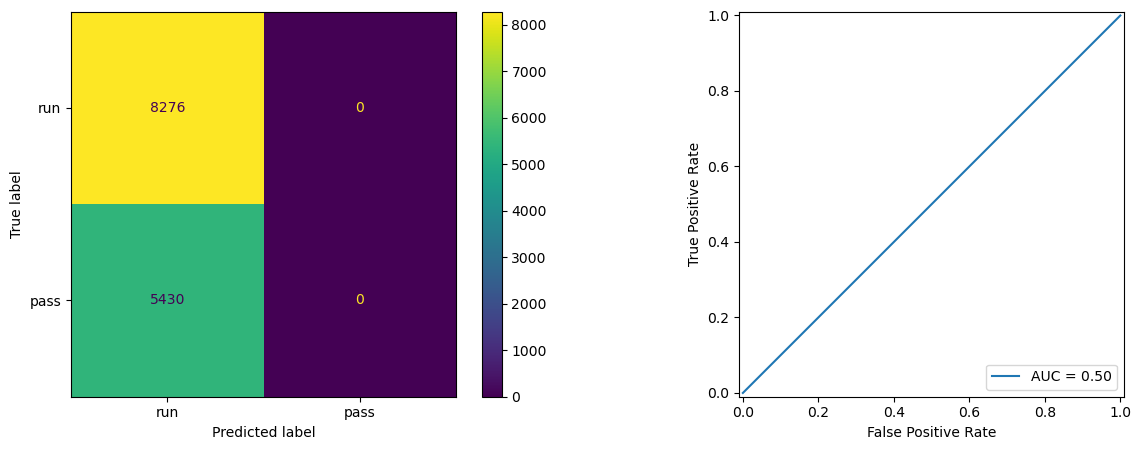

In [28]:
modeller = ModelTrainer(
    "Dummy", 
    DummyClassifier(),
    None
)
modeller.run()

### Logistic Regression

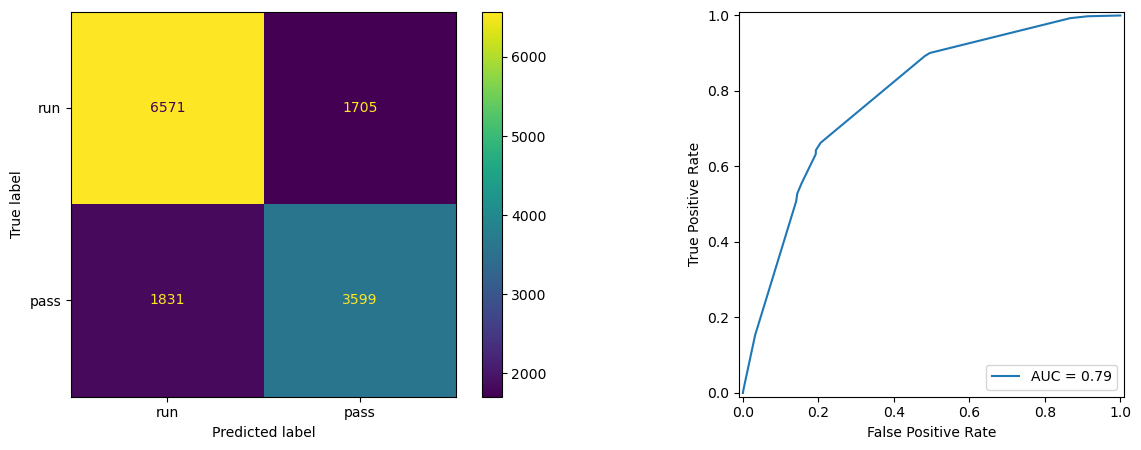

In [29]:
model_name = f"LogisticRegression (fit_intercept = {logistic_regression__fit_intercept}, penalty = {logistic_regression__penalty}, C = {logistic_regression__C}, class_weight = {logistic_regression__class_weight}, solver = {logistic_regression__solver})"
model = LogisticRegression(fit_intercept = logistic_regression__fit_intercept,
                           penalty = logistic_regression__penalty,
                           C = logistic_regression__C,
                           class_weight = logistic_regression__class_weight,
                           solver = logistic_regression__solver)

ModelTrainer(model_name, 
             Pipeline([
                 ('scaler', StandardScaler()), 
                 ('regression', model)
            ]),
            "lr",
            selected_features=logistic_regression__features).run()

### K-Nearest Neighbors

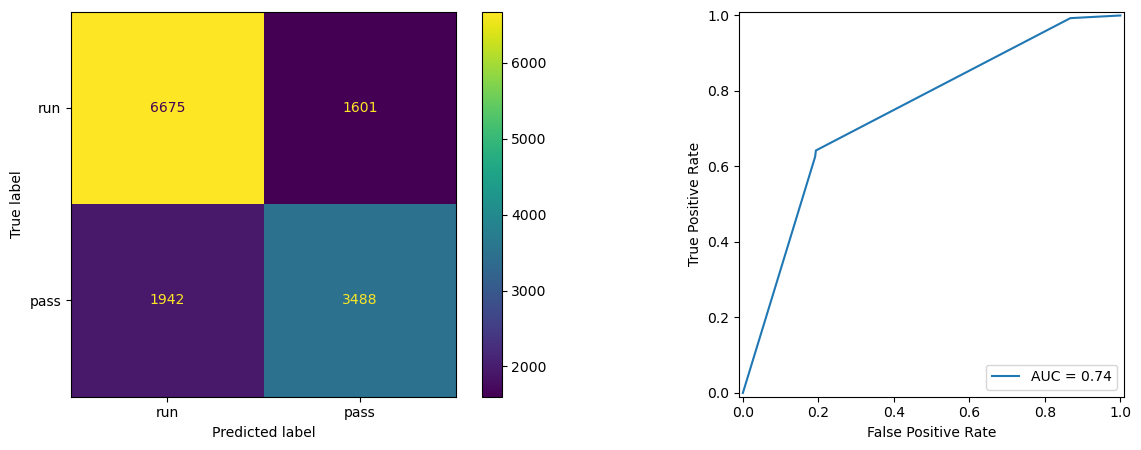

In [30]:
model_name = f"K-Nearest Neighbors (algorithm = {kneighbors__algorithm}, n_neighbors = {kneighbors__n_neighbors}, weights = {kneighbors__weights})"
model = KNeighborsClassifier(algorithm = kneighbors__algorithm,
                             n_neighbors = kneighbors__n_neighbors,
                             weights = kneighbors__weights)
ModelTrainer(model_name, 
             Pipeline([
                 ('scaler', StandardScaler()), 
                 ('regression', model)
            ]),
            "kn",
            selected_features=kneighbors__features).run()

### Decision Tree

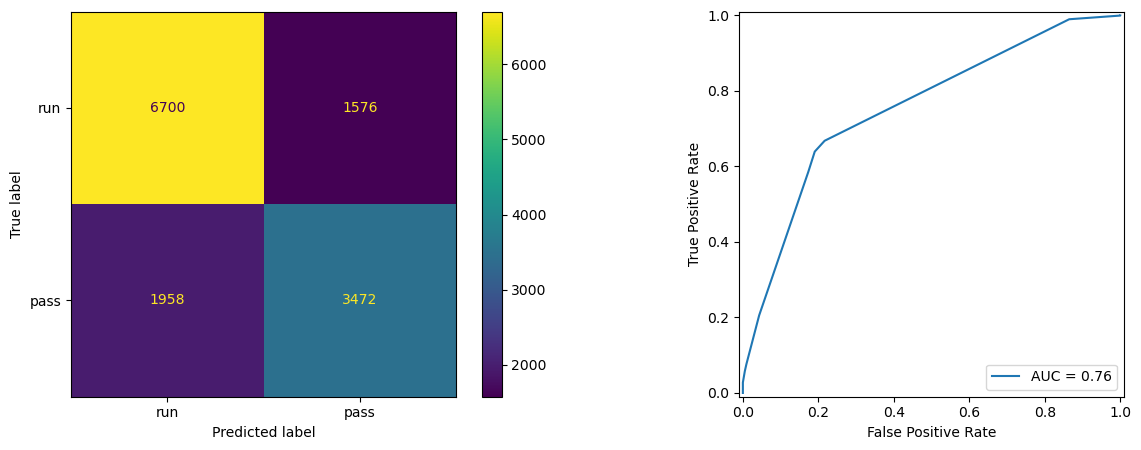

In [31]:
# for max_depth in range(1, 30):
model_name = f"DecisionTreeClassifier with (criterion={decision_tree__criterion}, max_depth={decision_tree__max_depth}, max_features={decision_tree__max_features})"
model = DecisionTreeClassifier(criterion=decision_tree__criterion, 
                                    max_depth=decision_tree__max_depth, 
                                    max_features=decision_tree__max_features)
ModelTrainer(model_name, 
            Pipeline([
                ('regression', model)
            ]),
            "dt",
            selected_features=decision_tree__features).run()

### Support Vector Machines

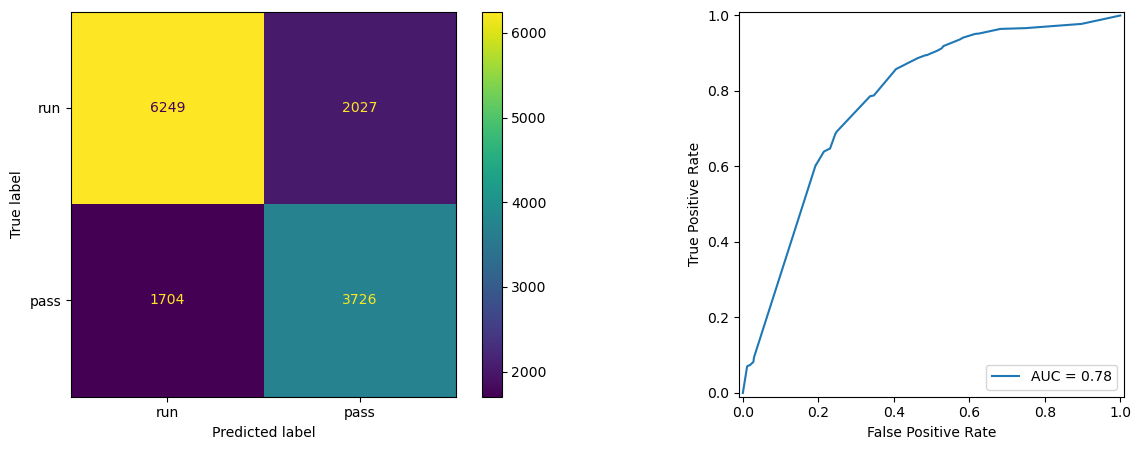

In [32]:
svc = SVC() #kernel=PARAM_SVM_KERNEL, gamma=PARAM_SVM_GAMMA, C=PARAM_SVM_C)
model_name = f"SVM (default params)"

ModelTrainer(model_name, 
            Pipeline([
                ('regression', model)
            ]),
            "sv").run()

### Random Forest

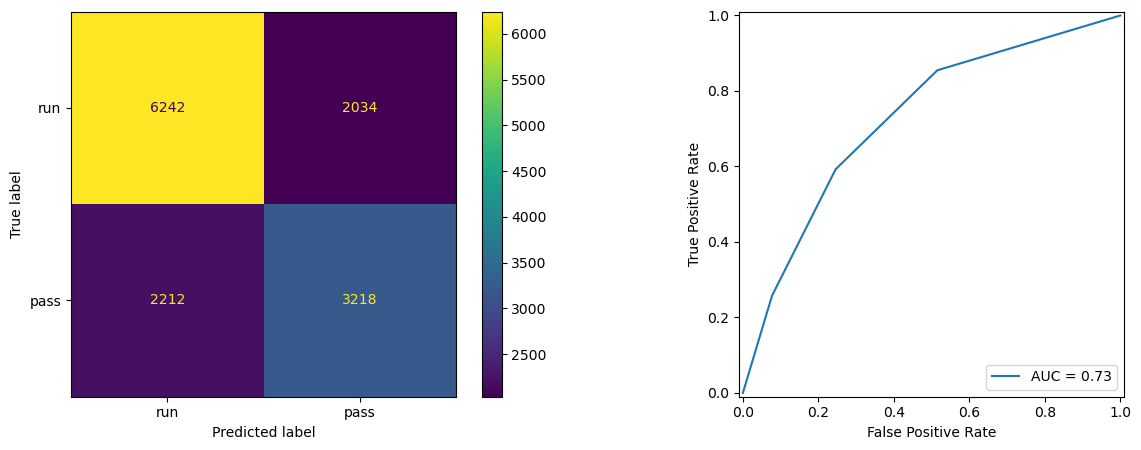

In [33]:
model_name = f"RandomForestClassifier with (n_estimators={random_forest__n_estimators}, max_features={random_forest__max_features})"
model = RandomForestClassifier(n_estimators=random_forest__n_estimators, 
                               max_features=random_forest__max_features,
                               oob_score=True)
ModelTrainer(model_name, 
            Pipeline([
                ('regression', model)
            ]),
            "rf").run()

### Gradient Boosting Ensemble

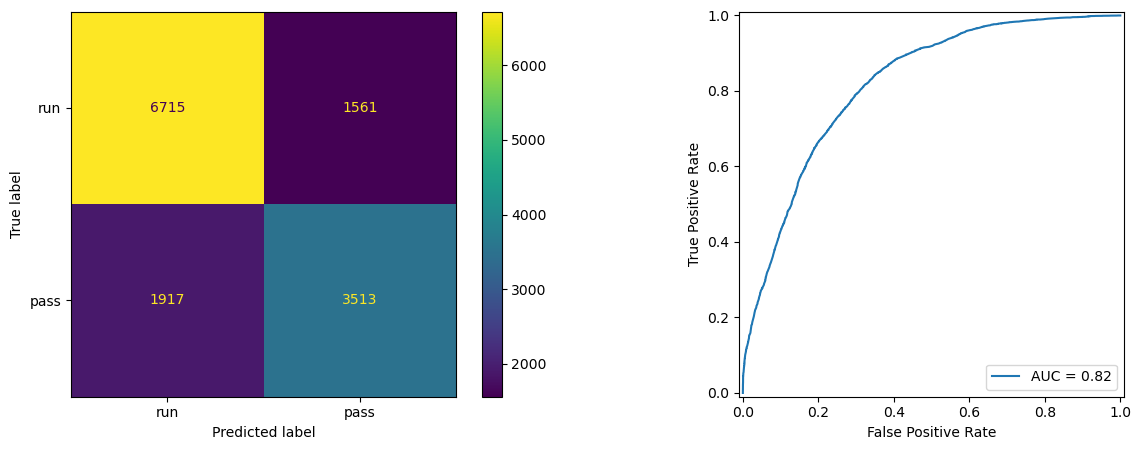

In [34]:
model_name = f"GradientBoostingClassifier with (n_estimators={gradient_boost__n_estimators})"
model = GradientBoostingClassifier(n_estimators=gradient_boost__n_estimators)
ModelTrainer(model_name, 
            Pipeline([
                ('regression', model)
            ]),
            "gb").run()

### Extreme Gradient Boost

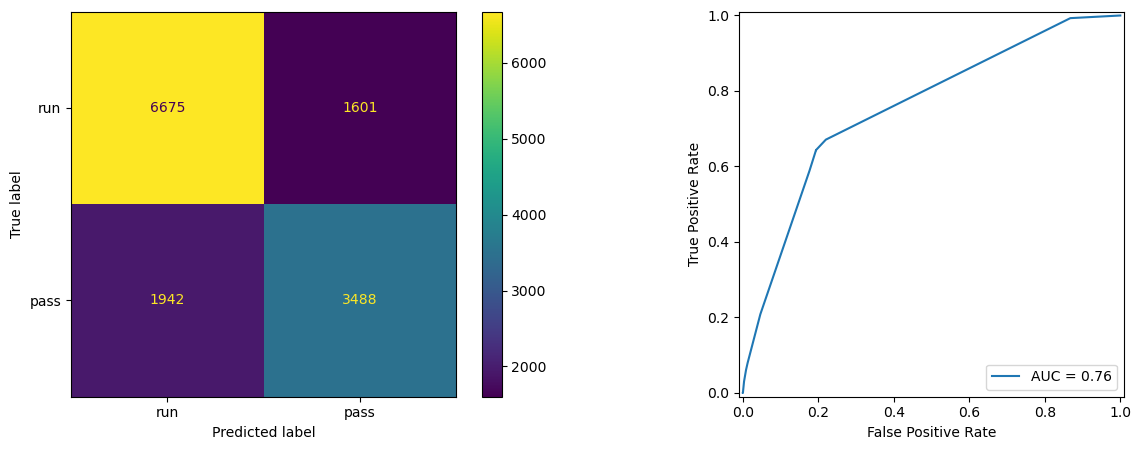

In [35]:
model_name = f"XGBClassifier (n_estimators={extremegradientboost__n_estimators}, max_depth={extremegradientboost__max_depth}, learning_rate={extremegradientboost__learning_rate})"
model = XGBClassifier(n_estimators=extremegradientboost__n_estimators, 
                      max_depth=extremegradientboost__max_depth, 
                      learning_rate=extremegradientboost__learning_rate)

ModelTrainer(model_name, 
             Pipeline([
                 ('scaler', StandardScaler()), 
                 ('regression', model)
            ]),
            "xg",
            use_label_encoder=True,
            selected_features=extremegradientboost__features).run()

# Post Training

## Summary of hyperparameters and model output

In [36]:
print_best_params("All Hyperparameters", all_best_params)
print_best_features()
show_run_output()

*Best Run is 0.746243 from GradientBoostingClassifier with (n_estimators=42)*

| Model | Features | Train Time | Train Accuracy | Test Accuracy |
| ----- | -------- | ---------- | -------------  | -----------   |
| Dummy | 0 | 0.01 secs | 0.6038 | 0.6038 |
| LogisticRegression (fit_intercept = True, penalty = l1, C = 1.0, class_weight = balanced, solver = liblinear) | 61 | 0.01 secs | 0.7428 | 0.7420 |
| K-Nearest Neighbors (algorithm = auto, n_neighbors = 10, weights = None) | 61 | 0.10 secs | 0.7395 | 0.7415 |
| DecisionTreeClassifier with (criterion=entropy, max_depth=6, max_features=None) | 61 | 0.01 secs | 0.7403 | 0.7422 |
| SVM (default params) | 61 | 0.02 secs | 0.7709 | 0.7278 |
| RandomForestClassifier with (n_estimators=3, max_features=8) | 61 | 0.02 secs | 0.9359 | 0.6902 |
| GradientBoostingClassifier with (n_estimators=42) | 61 | 0.10 secs | 0.7676 | 0.7462 |
| XGBClassifier (n_estimators=18, max_depth=1, learning_rate=1) | 61 | 0.02 secs | 0.7395 | 0.0000 |


## Evaluating Models

### Automation Layer

In [37]:
model_prefixes = {'lr':"Logistic Regression", 'kn': "KNN", 'dt': "Decision Tree", 'sv': "SVM", 'rf': "Random Forest", 'gb': "Gradient Boost", 'xg': "XGBClassifier"}

def calculate_model_accuracy():
    if not IS_TRAINING_MODE:
        print("This function only available during training mode")
        return
    X_test["actual"] = y_test
    for model in model_prefixes:
        print(f"Calculating accuracy for {model_prefixes[model]}")
        X_test[f'{model}_acc'] = X_test.apply(lambda p: p[f'{model}_pred'] == p.actual, axis = 1) 

scenarios = {'lr':[], 'kn': [], 'dt': [], 'sv': [], 'rf': [], 'gb': [], 'xg': []}
def calculate_combined_accuracy(df, type_prefix, actual=None):
    if not IS_TRAINING_MODE:
        print("This function only available during training mode")
        return
    
    show_table = False
    if show_table:
        print("| Model | lr | kn | dt | sv | rf | gb |  xg | best |")
        print("| ----- | -- | -- | -- | -- | -- | -- |  -- | -- |")
    else:
        print("Model\t\tlr\tkn\tdt\tsv\trf\tgb\txg\tbest")

    # when no features, we're just checking
    features = [item for item in df.columns if item.startswith(type_prefix)]
    if len(features) == 0:
        best_name = ""
        best_acc = 0
        row = f"| {type_prefix} | " if show_table else f"{type_prefix}\t"
        for m in model_prefixes:
            model_accuracy = f"{m}_acc"
            mean_acc = df[model_accuracy].mean()
            row += f" {mean_acc:.2f} |" if show_table else f"{mean_acc:.2f}\t"
            if mean_acc > best_acc:
                best_acc = mean_acc
                best_name = m
            if actual is not None:
                diff = f"outperformed by {(mean_acc - actual)*100:.1f}" if mean_acc > actual else f"underperformed by {(actual - mean_acc)*100:.1f}"
                scenarios[m].append(f"- {type_prefix}: predicted {mean_acc:.2f} (actual {actual:.2f}), {diff}")
        print(row)
        print(f"The best model is {model_prefixes[best_name]} with an accuracy of {best_acc:.2f}")
    else:
        best_score = 0.0
        best_model = ""
        for feature in features:
            pretty_feature = feature.replace(f"{type_prefix}_", "")
            row = f"| {pretty_feature} | " if show_table else f"{feature.ljust(15)}\t"
            best = 0.0
            for m in model_prefixes:
                model_accuracy = f"{m}_acc"
                mean_acc = df[df[feature] == 1][model_accuracy].mean()
                if mean_acc > best_score:
                    best_score = mean_acc
                    best_model = f"Model {m} had the highest accuracy of {mean_acc:.4f} with {pretty_feature}"
                if mean_acc > best:
                    best = mean_acc
                row += f" {mean_acc:.2f} |" if show_table else f"{mean_acc:.2f}\t"
            row += f" {best:.4f} |" if show_table else f"{best:.4f}\t"
            print(row)
        print(best_model)
    print("")

def print_scenarios():
    for prefix in scenarios:
        print(f"{prefix} - {model_prefixes[prefix]}")
        for scenario in scenarios[prefix]:
            print(scenario)

## Evaluating the models

In [38]:
calculate_model_accuracy()

Calculating accuracy for Logistic Regression
Calculating accuracy for KNN
Calculating accuracy for Decision Tree
Calculating accuracy for SVM
Calculating accuracy for Random Forest
Calculating accuracy for Gradient Boost
Calculating accuracy for XGBClassifier


### Scenario: Which models perform the best based on the formation

In [39]:
calculate_combined_accuracy(X_test, 'form')

Model		lr	kn	dt	sv	rf	gb	xg	best
form_EMPTY     	0.97	0.97	0.97	0.95	0.94	0.97	0.97	0.9665	
form_I_FORM    	0.71	0.71	0.71	0.70	0.65	0.72	0.71	0.7161	
form_JUMBO     	0.84	0.84	0.84	0.81	0.68	0.81	0.84	0.8426	
form_MUDDLE    	0.00	0.00	1.00	0.48	0.33	0.52	0.00	1.0000	
form_PISTOL    	0.65	0.65	0.65	0.68	0.63	0.71	0.65	0.7067	
form_SHOTGUN   	0.75	0.75	0.75	0.73	0.70	0.75	0.75	0.7528	
form_SINGLEBACK	0.67	0.67	0.67	0.66	0.60	0.66	0.67	0.6658	
form_VICTORY   	1.00	1.00	1.00	0.97	0.78	1.00	1.00	1.0000	
form_WILDCAT   	0.85	0.85	0.69	0.86	0.65	0.78	0.85	0.8649	
Model dt had the highest accuracy of 1.0000 with MUDDLE



### Evalutating: Which teams were the most and least predictable

In [52]:
# this will generate the full scenario analysis for the report; no need to generate this every time
if DEBUG_PARAMETER:
    calculate_combined_accuracy(X_test, 'team')

## Real World Scenarios

### Scenario: QB Spike

In [41]:
x = X_test
calculate_combined_accuracy(x[abs(x.form_PISTOL)], 'Scenario 1) pistol formation', 0.6474)

Model		lr	kn	dt	sv	rf	gb	xg	best
Scenario 1) pistol formation	0.65	0.65	0.65	0.68	0.63	0.71	0.65	
The best model is Gradient Boost with an accuracy of 0.71



### Scenario: Wildcat

In [42]:
x = X_test
calculate_combined_accuracy(x[abs(x.form_WILDCAT)], 'Scenario 2) wildcat formation', 0.8506)

Model		lr	kn	dt	sv	rf	gb	xg	best
Scenario 2) wildcat formation	0.85	0.85	0.69	0.86	0.65	0.78	0.85	
The best model is SVM with an accuracy of 0.86



### Scenario: Shotgun

In [43]:
x = X_test
calculate_combined_accuracy(x[abs(x.form_SHOTGUN)], 'Scenario 3) shotgun formation', 0.7454)

Model		lr	kn	dt	sv	rf	gb	xg	best
Scenario 3) shotgun formation	0.75	0.75	0.75	0.73	0.70	0.75	0.75	
The best model is Gradient Boost with an accuracy of 0.75



### Scenario: Which models perform the best when the score is close

In [44]:
x = X_test
calculate_combined_accuracy(x[abs(x.score_offset) <= 8], 'Scenario 4) one score game', 0.5921)

Model		lr	kn	dt	sv	rf	gb	xg	best
Scenario 4) one score game	0.73	0.73	0.73	0.71	0.68	0.73	0.73	
The best model is Logistic Regression with an accuracy of 0.73



### Scenario: Which models perform the best on 1st and 10
The best model is Decision Tree with an accuracy of 0.68

In [45]:
x = X_test
calculate_combined_accuracy(x[(x.down_1 == True) & (X_test.yardsToGo == 10)], "Scenario 5) 1st and 10", 0.5042)

Model		lr	kn	dt	sv	rf	gb	xg	best
Scenario 5) 1st and 10	0.68	0.68	0.68	0.68	0.62	0.69	0.68	
The best model is Gradient Boost with an accuracy of 0.69



### Scenario: Which models perform the best on 3rd and long
The best model is Gradient Boost with an accuracy of 0.95

In [46]:
x = X_test
calculate_combined_accuracy(x[(x.down_3 == True) & (X_test.yardsToGo >= 8)], "Scenario 6) 3rd and long", 0.9217)

Model		lr	kn	dt	sv	rf	gb	xg	best
Scenario 6) 3rd and long	0.94	0.94	0.94	0.92	0.94	0.95	0.94	
The best model is Gradient Boost with an accuracy of 0.95



### Scenario: Which models perform the best when teams are losing by 2 scores
The best model is Gradient Boost with an accuracy of 0.74

In [47]:
x = X_test
calculate_combined_accuracy(x[(x.score_offset <= 14)], "Scenario 7) losing by 2 scores", 0.6104)

Model		lr	kn	dt	sv	rf	gb	xg	best
Scenario 7) losing by 2 scores	0.74	0.74	0.74	0.73	0.69	0.74	0.74	
The best model is Gradient Boost with an accuracy of 0.74



### Scenario: Which models perform the best when teams are winning by 2 scores
The best model is SVM with an accuracy of 0.79

In [48]:
x = X_test
calculate_combined_accuracy(x[(x.score_offset >= 14)], "Scenario 8) winning by 2 scores", 0.5354)

Model		lr	kn	dt	sv	rf	gb	xg	best
Scenario 8) winning by 2 scores	0.76	0.76	0.76	0.78	0.69	0.79	0.76	
The best model is Gradient Boost with an accuracy of 0.79



### Scenario: 3rd and Medium (3-8)

In [49]:
x = X_test
calculate_combined_accuracy(x[(x.yardsToGo >= 3) & (x.yardsToGo <= 8)], "Scenario 9) 3rd and medium (3-8)", 0.6792)

Model		lr	kn	dt	sv	rf	gb	xg	best
Scenario 9) 3rd and medium (3-8)	0.77	0.77	0.77	0.75	0.73	0.77	0.77	
The best model is Gradient Boost with an accuracy of 0.77



### Scenario: Which models perform when it's 4th and 2 or less, less than 2 mins, trailing by 4-7 points, between the 40s
The best model is SVM with an accuracy of 0.93

In [50]:
x = X_test
calculate_combined_accuracy(x[(x.score_offset > 0) & (x.quarter_4) & (x.down_4) & (x.yardsToGo <= 5)], 
                             "Scenario 10) trailing in the 4Q, 4th and 5 or less", 0.6)

Model		lr	kn	dt	sv	rf	gb	xg	best
Scenario 10) trailing in the 4Q, 4th and 5 or less	0.86	0.79	0.86	0.93	0.86	0.86	0.79	
The best model is SVM with an accuracy of 0.93



## Grading the Evaluations

In [51]:
def how_many(df2, desc):
    times = df2.shape[0]
    pass_rate = df2[TARGET_FEATURE].transform(lambda x: x == "pass").mean()
    run_rate = 1 - pass_rate
    print(f"For {desc.ljust(25)}  {times}\t{pass_rate:.4f}\t{run_rate:.4f}")

# this will generate the full scenario analysis for the report; no need to generate this every time
if DEBUG_PARAMETER:
    # how_many(x[(x.form_PISTOL)], "Pistol")

    x = df
    print(f"{'Situation'.ljust(30)} times\tpass\trun")
    how_many(x[(x.form_PISTOL)], "Pistol")
    how_many(x[(x.form_WILDCAT)], "Wildcat")
    how_many(x[(x.form_SHOTGUN)], "Shotgun")
    how_many(x[abs(x.score_offset) <= 8], "one score game")
    how_many(x[(x.down_1 == True) & (x.yardsToGo == 10)], "When it's 1st and 10")
    how_many(x[(x.down_3 == True) & (x.yardsToGo >= 8)], "When it's 3rd and long")
    how_many(x[(x.score_offset <= 14)], "When losing by 2 scores")
    how_many(x[(x.score_offset >= 14)], "When winning by 2 scores")
    how_many(x[(x.yardsToGo >= 3) & (x.yardsToGo <= 8)], "3rd and Medium (3-8)")
    how_many(x[(x.score_offset > 0) & (x.quarter_4) & (x.down_4) & (x.yardsToGo <= 5)], 
                                "4Q, 4th and 5 or less, trailing")
    print("")

    print_scenarios()
